In [32]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from rdkit.Chem import AddHs
from rdkit.Chem import inchi
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize import Standardizer
from rdkit.Chem import MolStandardize
from collections import Counter

def standardize_jumpcp(smiles):
    standardizer = Standardizer()
    smiles_original = smiles

    # Read SMILES and convert it to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
 
    try:
        smiles_clean_counter = Counter()
        mol_dict = {}
        is_finalize = False

        for _ in range(5):
            
            #This solved phosphate oxidation in most cases but introduces a problem for some compounds: eg. geldanamycin where the stable strcutre is returned
            inchi_standardised = Chem.MolToInchi(mol)
            mol = Chem.MolFromInchi(inchi_standardised)
            
            # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
            mol = rdMolStandardize.Cleanup(mol) 
            # if many fragments, get the "parent" (the actual mol we are interested in) 
            mol = rdMolStandardize.FragmentParent(mol)
            # try to neutralize molecule
            uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
            
            mol = uncharger.uncharge(mol)# standardize molecules using MolVS and RDKit
            mol = standardizer.charge_parent(mol)
            mol = standardizer.isotope_parent(mol)
            mol = standardizer.stereo_parent(mol)
            
            #Normalize tautomers 
            #Method 1
            normalizer = MolStandardize.tautomer.TautomerCanonicalizer()
            mol = normalizer.canonicalize(mol)
            
            #Method 2
            te = rdMolStandardize.TautomerEnumerator() # idem
            mol = te.Canonicalize(mol)
            
            #Method 3
            mol = standardizer.tautomer_parent(mol)
       
    
            #Final Rules
            mol = standardizer.standardize(mol)
            mol_standardized = mol

            # convert mol object back to SMILES
            smiles_standardized = Chem.MolToSmiles(mol_standardized)

            if smiles == smiles_standardized:
                is_finalize = True
                break

            smiles_clean_counter[smiles_standardized] += 1
            if smiles_standardized not in mol_dict:
                mol_dict[smiles_standardized] = mol_standardized

            smiles = smiles_standardized
            mol = Chem.MolFromSmiles(smiles)

        if not is_finalize:
            # If the standardization process is not finalized, we choose the most common SMILES from the counter
            smiles_standardized = smiles_clean_counter.most_common()[0][0]
            # ... and the corresponding mol object
            #mol_standardized = mol_dict[smiles_standardized]
                    
        return smiles_standardized 
    
    except:     
        
        return "Cannot_do"
    
def check_carbon(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'C':
                return smiles
    return "Cannot_do"

def inchi_from_standardised_smile(value):

    try: return Chem.MolToInchi(Chem.MolFromSmiles(value))
    except: return "Cannot_do"

def inchi_to_smiles(value):

    try: return Chem.MolToSmiles(Chem.MolFromInchi(value))
    except: return "Cannot_do"


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [57]:
data = pd.read_csv("input/tox24_challenge_train.csv")
data

,SMILES,activity
0,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,12.3
1,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,94.1
2,CCCCCCCCCCCCCC(=O)OCC(O)CO,38.1
3,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,11.8
4,CCCCCCCCCC=CCC1CC(=O)OC1=O,98.4
...,...,...
1007,COC1=C(OC)C(=CC=C1)[C@H](O)C2CCN(CCC3=CC=C(F)C...,-16.9
1008,CC(=O)CC(C1=CC=CC=C1)C2=C(O)C3=CC=CC=C3OC2=O,93.2
1009,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(O)=CC(O)=C2)C(=O)O1,28.1
1010,OC(=O)CN1C(=O)N(CC2=CC=C(Br)C=C2F)C(=O)C3=C1C=...,59.0


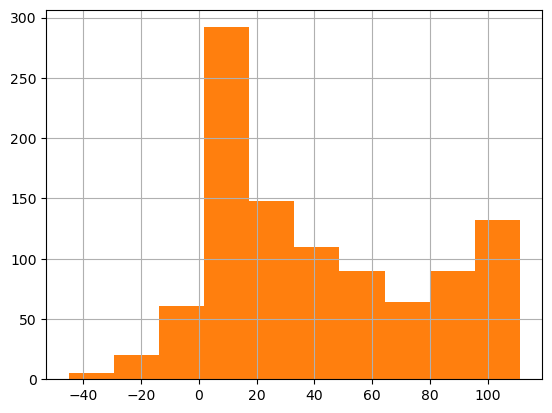

In [59]:
data.activity.hist()
plt.show()

In [34]:
data.columns

Index(['SMILES', 'activity'], dtype='object')

In [36]:
data = data[["SMILES", "activity"]].dropna().reset_index(drop=True)
data

,SMILES,activity
0,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,12.3
1,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,94.1
2,CCCCCCCCCCCCCC(=O)OCC(O)CO,38.1
3,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,11.8
4,CCCCCCCCCC=CCC1CC(=O)OC1=O,98.4
...,...,...
1007,COC1=C(OC)C(=CC=C1)[C@H](O)C2CCN(CCC3=CC=C(F)C...,-16.9
1008,CC(=O)CC(C1=CC=CC=C1)C2=C(O)C3=CC=CC=C3OC2=O,93.2
1009,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(O)=CC(O)=C2)C(=O)O1,28.1
1010,OC(=O)CN1C(=O)N(CC2=CC=C(Br)C=C2F)C(=O)C3=C1C=...,59.0


In [38]:
from rdkit import RDLogger
import pandas as pd
# Suppress RDKit error logs
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Apply the standardize_oasis function
data['Standardized_SMILES'] = data["SMILES"].parallel_apply(standardize_jumpcp)
# Convert standardized SMILES to InChI
data['Standardized_InChI'] = data['Standardized_SMILES'].parallel_apply(inchi_from_standardised_smile)

#Flag ompounds without carbon as cannot_do
data['Standardized_SMILES'] = data['Standardized_SMILES'].parallel_apply(check_carbon)
    
# Filter out SMILES strings that couldn't be standardized
filtered_data = data[data['Standardized_SMILES'] != "Cannot_do"]
# Filter out InChI strings that couldn't be standardized
filtered_data = filtered_data[filtered_data['Standardized_InChI'] != "Cannot_do"].reset_index(drop=True)
  
filtered_data

Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000


,SMILES,activity,Standardized_SMILES,Standardized_InChI
0,CC1(C)[C@@H]2C[C@H]1C(=C)CC2,12.3,C=C1CCC2CC1C2(C)C,"InChI=1S/C10H16/c1-7-4-5-8-6-9(7)10(8,2)3/h8-9..."
1,COC(=O)C(C)OC1=CC=C(OC2=CC=C(Cl)C=C2Cl)C=C1,94.1,COC(=O)C(C)Oc1ccc(Oc2ccc(Cl)cc2Cl)cc1,InChI=1S/C16H14Cl2O4/c1-10(16(19)20-2)21-12-4-...
2,CCCCCCCCCCCCCC(=O)OCC(O)CO,38.1,CCCCCCCCCCCCCC(=O)OCC(O)CO,InChI=1S/C17H34O4/c1-2-3-4-5-6-7-8-9-10-11-12-...
3,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,11.8,CC(=O)OC1CC2CCC1(C)C2(C)C,"InChI=1S/C12H20O2/c1-8(13)14-10-7-9-5-6-12(10,..."
4,CCCCCCCCCC=CCC1CC(=O)OC1=O,98.4,CCCCCCCCCC=CCc1cc(O)oc1O,InChI=1S/C16H26O3/c1-2-3-4-5-6-7-8-9-10-11-12-...
...,...,...,...,...
995,COC1=C(OC)C(=CC=C1)[C@H](O)C2CCN(CCC3=CC=C(F)C...,-16.9,COc1cccc(C(O)C2CCN(CCc3ccc(F)cc3)CC2)c1OC,InChI=1S/C22H28FNO3/c1-26-20-5-3-4-19(22(20)27...
996,CC(=O)CC(C1=CC=CC=C1)C2=C(O)C3=CC=CC=C3OC2=O,93.2,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,InChI=1S/C19H16O4/c1-12(20)11-15(13-7-3-2-4-8-...
997,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(O)=CC(O)=C2)C(=O)O1,28.1,CC1CCCC(=O)CCC=CCc2cc(O)cc(O)c2C(=O)O1,InChI=1S/C18H22O5/c1-12-6-5-9-14(19)8-4-2-3-7-...
998,OC(=O)CN1C(=O)N(CC2=CC=C(Br)C=C2F)C(=O)C3=C1C=...,59.0,O=C(O)Cn1c(=O)n(Cc2ccc(Br)cc2F)c(=O)c2ccc(Cl)cc21,InChI=1S/C17H11BrClFN2O4/c18-10-2-1-9(13(20)5-...


In [39]:
filtered_data=filtered_data.groupby("Standardized_SMILES").median().reset_index(drop=False)
filtered_data

,Standardized_SMILES,activity
0,BrCCBr,13.4
1,C#CC(C)(C)NC(=O)c1cc(Cl)cc(Cl)c1,64.8
2,C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21C,15.8
3,C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21CC,18.0
4,C#CC1(O)CCC2C3CCc4cc(O)ccc4C3CCC21C,87.9
...,...,...
970,c1ccc2c(c1)CCCC2,8.9
971,c1ccc2c(c1)sc1ccccc12,15.7
972,c1ccc2ccccc2c1,34.8
973,c1ccc2ncccc2c1,34.3


In [41]:
# Remove outliers from the 'Potentiation' column
Q1 = filtered_data['activity'].quantile(0.25)
Q3 = filtered_data['activity'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_data_no_outliers = filtered_data[(filtered_data['activity'] >= lower_bound) & 
                                          (filtered_data['activity'] <= upper_bound)].reset_index(drop=True)

# Display the filtered data without outliers
filtered_data_no_outliers

,Standardized_SMILES,activity
0,BrCCBr,13.4
1,C#CC(C)(C)NC(=O)c1cc(Cl)cc(Cl)c1,64.8
2,C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21C,15.8
3,C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21CC,18.0
4,C#CC1(O)CCC2C3CCc4cc(O)ccc4C3CCC21C,87.9
...,...,...
970,c1ccc2c(c1)CCCC2,8.9
971,c1ccc2c(c1)sc1ccccc12,15.7
972,c1ccc2ccccc2c1,34.8
973,c1ccc2ncccc2c1,34.3


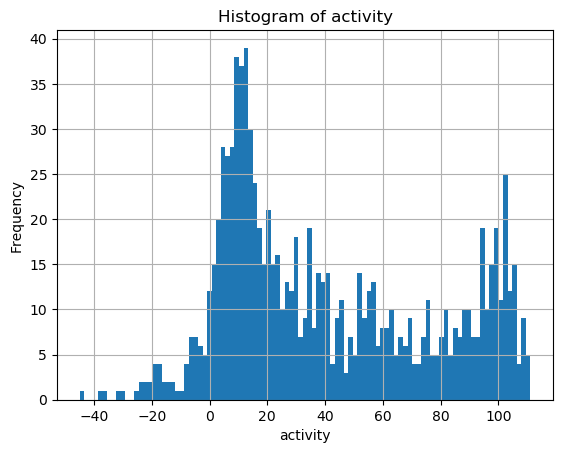

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bins with more intervals between 100 and 200
bins = np.concatenate([
    np.linspace(filtered_data_no_outliers['activity'].min(), filtered_data_no_outliers['activity'].max(), 100)
])

# Plot the histogram
filtered_data_no_outliers['activity'].hist(bins=bins)
plt.xlabel('activity')
plt.ylabel('Frequency')
plt.title('Histogram of activity')
plt.show()

In [43]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

def calculate_molwt(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol)
    return None

def calculate_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolLogP(mol)
    return None
def calculate_QED(smiles):
    mol=Chem.MolFromSmiles(smiles)
    if mol:
        return Chem.QED.default(mol)
    return

filtered_data_no_outliers['MolWt'] =filtered_data_no_outliers['Standardized_SMILES'].apply(calculate_molwt)
filtered_data_no_outliers['LogP'] = filtered_data_no_outliers['Standardized_SMILES'].apply(calculate_logp)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [44]:
filtered_data_no_outliers.to_csv("input/tox24_challenge_train_all_ready.csv.gz", compression='gzip', index=False)

In [ ]:
# Test compounds

In [45]:
test_df = pd.read_csv("input/tox24_challenge_test.csv")
test_df

,SMILES
0,CC1=CC[C@H]2C[C@@H]1C2(C)C
1,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O
2,CC(C)=CCC/C(/C)=C/CO
3,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C
4,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O
...,...
495,CC1(OC(=O)N(C1=O)C2=CC(Cl)=CC(Cl)=C2)C=C
496,FC1(F)/C(=C\C(=O)N2CCC(N3CCCCC3)CC2)/C=4C(N(CC...
497,COP(=O)(OC)O/C(=C\Cl)/C1=C(Cl)C=C(Cl)C(Cl)=C1
498,C1=CC=N(=O)C([S-])=C1.C1=CC=N(=O)C([S-])=C1.[Z...


In [46]:
from rdkit import RDLogger
import pandas as pd
# Suppress RDKit error logs
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Apply the standardize_oasis function
test_df['Standardized_SMILES'] = test_df["SMILES"].parallel_apply(standardize_jumpcp)
# Convert standardized SMILES to InChI
test_df['Standardized_InChI'] = test_df['Standardized_SMILES'].parallel_apply(inchi_from_standardised_smile)

#Flag ompounds without carbon as cannot_do
test_df['Standardized_SMILES'] = data['Standardized_SMILES'].parallel_apply(check_carbon)
test_df

Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000
Tautomer enumeration stopped at maximum 1000


,SMILES,Standardized_SMILES,Standardized_InChI
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,C=C1CCC2CC1C2(C)C,"InChI=1S/C10H16/c1-7-4-5-8-6-9(7)10(8,2)3/h4,8..."
1,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,COC(=O)C(C)Oc1ccc(Oc2ccc(Cl)cc2Cl)cc1,InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-7(2...
2,CC(C)=CCC/C(/C)=C/CO,CCCCCCCCCCCCCC(=O)OCC(O)CO,"InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7..."
3,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,CC(=O)OC1CC2CCC1(C)C2(C)C,InChI=1S/C20H33NO/c1-15(12-21-13-16(2)22-17(3)...
4,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,CCCCCCCCCC=CCc1cc(O)oc1O,InChI=1S/C13H15NO3S/c1-3-8(2)11(13(16)17)14-12...
...,...,...,...
495,CC1(OC(=O)N(C1=O)C2=CC(Cl)=CC(Cl)=C2)C=C,CCCCCCOC(=O)CCCCC(=O)OCCCCCC,InChI=1S/C12H9Cl2NO3/c1-3-12(2)10(16)15(11(17)...
496,FC1(F)/C(=C\C(=O)N2CCC(N3CCCCC3)CC2)/C=4C(N(CC...,CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCC,InChI=1S/C35H38F2N4O4/c1-24-28(15-22-45-24)33(...
497,COP(=O)(OC)O/C(=C\Cl)/C1=C(Cl)C=C(Cl)C(Cl)=C1,C=CC(=C)CCCC(C)(C)O,"InChI=1S/C10H9Cl4O4P/c1-16-19(15,17-2)18-10(5-..."
498,C1=CC=N(=O)C([S-])=C1.C1=CC=N(=O)C([S-])=C1.[Z...,CC(C)COC(=O)CCCCC(=O)OCC(C)C,"InChI=1S/C5H5NOS/c7-6-4-2-1-3-5(6)8/h1-4,7H"


In [50]:
    
# Filter out SMILES strings that couldn't be standardized
no_SMILES = test_df[test_df['Standardized_SMILES'] == "Cannot_do"]
no_SMILES

,SMILES,Standardized_SMILES,Standardized_InChI
301,CCCCCCC(=O)OCC,Cannot_do,InChI=1S/C9H18O2/c1-3-5-6-7-8-9(10)11-4-2/h3-8...
344,CC(C)CCO,Cannot_do,"InChI=1S/C5H12O/c1-5(2)3-4-6/h5-6H,3-4H2,1-2H3"
409,CCCCN(CC)C(=O)SCCC,Cannot_do,InChI=1S/C10H21NOS/c1-4-7-8-11(6-3)10(12)13-9-...


In [52]:
test_df['Standardized_SMILES'] = test_df.apply(
    lambda row: row['SMILES'] if row['Standardized_SMILES'] == "Cannot_do" else row['Standardized_SMILES'],
    axis=1
)
test_df

,SMILES,Standardized_SMILES,Standardized_InChI
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,C=C1CCC2CC1C2(C)C,"InChI=1S/C10H16/c1-7-4-5-8-6-9(7)10(8,2)3/h4,8..."
1,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,COC(=O)C(C)Oc1ccc(Oc2ccc(Cl)cc2Cl)cc1,InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-7(2...
2,CC(C)=CCC/C(/C)=C/CO,CCCCCCCCCCCCCC(=O)OCC(O)CO,"InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7..."
3,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,CC(=O)OC1CC2CCC1(C)C2(C)C,InChI=1S/C20H33NO/c1-15(12-21-13-16(2)22-17(3)...
4,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,CCCCCCCCCC=CCc1cc(O)oc1O,InChI=1S/C13H15NO3S/c1-3-8(2)11(13(16)17)14-12...
...,...,...,...
495,CC1(OC(=O)N(C1=O)C2=CC(Cl)=CC(Cl)=C2)C=C,CCCCCCOC(=O)CCCCC(=O)OCCCCCC,InChI=1S/C12H9Cl2NO3/c1-3-12(2)10(16)15(11(17)...
496,FC1(F)/C(=C\C(=O)N2CCC(N3CCCCC3)CC2)/C=4C(N(CC...,CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCC,InChI=1S/C35H38F2N4O4/c1-24-28(15-22-45-24)33(...
497,COP(=O)(OC)O/C(=C\Cl)/C1=C(Cl)C=C(Cl)C(Cl)=C1,C=CC(=C)CCCC(C)(C)O,"InChI=1S/C10H9Cl4O4P/c1-16-19(15,17-2)18-10(5-..."
498,C1=CC=N(=O)C([S-])=C1.C1=CC=N(=O)C([S-])=C1.[Z...,CC(C)COC(=O)CCCCC(=O)OCC(C)C,"InChI=1S/C5H5NOS/c7-6-4-2-1-3-5(6)8/h1-4,7H"


In [55]:
filtered_data = test_df[test_df['Standardized_SMILES'] != "Cannot_do"][["Standardized_SMILES"]]
filtered_data.to_csv("input/tox24_challenge_test_all_ready.csv.gz", compression="gzip")

In [56]:
filtered_data

,Standardized_SMILES
0,C=C1CCC2CC1C2(C)C
1,COC(=O)C(C)Oc1ccc(Oc2ccc(Cl)cc2Cl)cc1
2,CCCCCCCCCCCCCC(=O)OCC(O)CO
3,CC(=O)OC1CC2CCC1(C)C2(C)C
4,CCCCCCCCCC=CCc1cc(O)oc1O
...,...
495,CCCCCCOC(=O)CCCCC(=O)OCCCCCC
496,CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCC
497,C=CC(=C)CCCC(C)(C)O
498,CC(C)COC(=O)CCCCC(=O)OCC(C)C
